## Import dataset 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
plt.style.use('ggplot')
%matplotlib inline

In [3]:
df_all = pd.read_csv('DCD_April.csv')

C:\Users\zfang\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_all.columns = [col.lower().replace(' ','_') for col in df_all.columns.tolist()]
df_all.columns = [col.lower().replace('/timestamp','') for col in df_all.columns.tolist()]

In [5]:
date_col = [col for col in df_all.columns.tolist() if 'date' in col]
df_all[date_col] = df_all[date_col].apply(pd.to_datetime,format = "%m/%d/%Y %H:%M:%S")

In [6]:
df_all.event_site_name.unique(),df_all.event_type.unique()

(array(['Nexium24hour', 'Centrum', 'Advil', 'Advil PM', 'Preparationh',
        'Emergenc', 'default'], dtype=object),
 array(['nexium24hour-buy.now', 'centrum-coupon.submit', 'sale.advil',
        'centrum-email.sign.up', 'sale.advilpm', 'sale.centrum',
        'preparationh-coupon.submit', 'preparationh-buy.now', 'sale.nexium',
        'preparationh-email.sign.up', 'advil pm-buy.now', 'advil-buy.now',
        'emergenc-buy.now', 'centrum-buy.now', 'sale.preparationh',
        'emergenc-coupon.submit', 'emergenc-email.sign.up',
        'emergenc-add.to.cart', 'sale.emergenc',
        'emergenc-freesample.submit', 'advil-coupon.submit',
        'advil-email.sign.up', 'nexium24hour-coupon.submit',
        'nexium24hour-email.sign.up', 'advil pm-coupon.submit',
        'advil pm-email.sign.up', 'nexium24hour-sweepstakes.social.share',
        'nexium24hour-sweepstakes.submit', 'emergenc-sale.online'], dtype=object))

In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253319 entries, 0 to 1253318
Data columns (total 22 columns):
unique_row_id           1253319 non-null object
cvo_sid                 1253319 non-null object
event_site_id           1253319 non-null int64
touchpoint_site_id      1253319 non-null int64
event_site_name         1253319 non-null object
touchpoint_site_name    1253319 non-null object
event_type              1253319 non-null object
event_id                1253319 non-null object
event_date              1253319 non-null datetime64[ns]
touchpoint_date         1253319 non-null datetime64[ns]
total_event_value       1253319 non-null float64
touchpoint_revenue      1253319 non-null float64
conversion              1253319 non-null float64
touchpoint_type         1027602 non-null object
first_touch_date        1253319 non-null datetime64[ns]
last_touch_date         1253319 non-null datetime64[ns]
source_1                1253319 non-null object
source_2                1253319 non-nu

## frequency on sales

conversion window 30days

continous window 14 days

max path length 30

event sales

sourse 1 not base


In [8]:
sale_df = df_all[df_all.event_type.str.contains('sale')]

In [9]:
sale_df = sale_df[sale_df.source_1!='base']

sale_df['touch_to_last'] = (sale_df.event_date-sale_df.touchpoint_date).dt.days

df_sale_convwin = sale_df[sale_df.touch_to_last<30]

In [10]:
df_sale_fre = pd.DataFrame({'count':df_sale_convwin.groupby('event_id')['event_id'].count()}).reset_index()

In [11]:
df_sale_fre_count = df_sale_fre.groupby('count')['count'].count().sort_index()[:30]

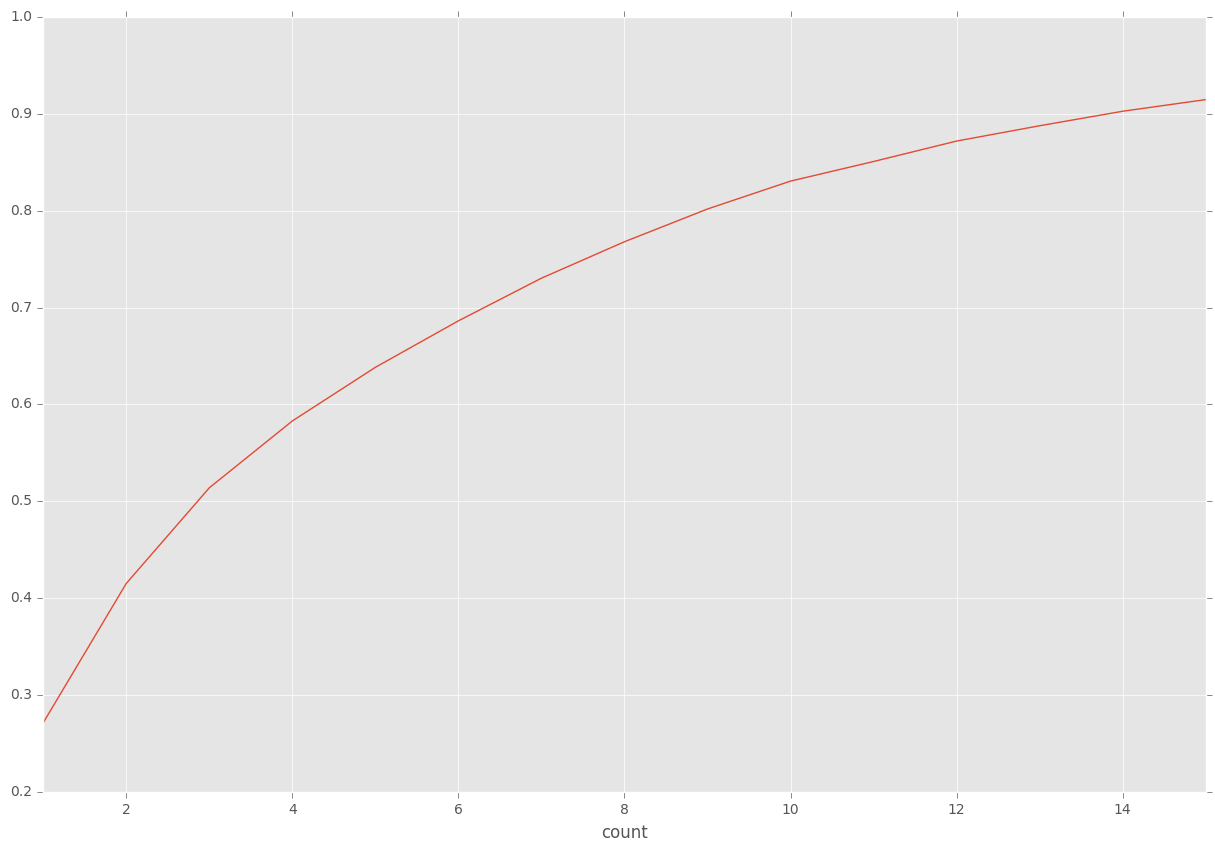

In [12]:
(df_sale_fre_count/df_sale_fre_count.sum()).cumsum()[:15].plot(figsize = (15,10))

## Feature Engineering

In [13]:
df_nobase=df_all[df_all['source_1']!='base']

In [14]:
df_nobase.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027602 entries, 0 to 1253318
Data columns (total 22 columns):
unique_row_id           1027602 non-null object
cvo_sid                 1027602 non-null object
event_site_id           1027602 non-null int64
touchpoint_site_id      1027602 non-null int64
event_site_name         1027602 non-null object
touchpoint_site_name    1027602 non-null object
event_type              1027602 non-null object
event_id                1027602 non-null object
event_date              1027602 non-null datetime64[ns]
touchpoint_date         1027602 non-null datetime64[ns]
total_event_value       1027602 non-null float64
touchpoint_revenue      1027602 non-null float64
conversion              1027602 non-null float64
touchpoint_type         1027602 non-null object
first_touch_date        1027602 non-null datetime64[ns]
last_touch_date         1027602 non-null datetime64[ns]
source_1                1027602 non-null object
source_2                1027602 non-nu

In [15]:
selected_col=['event_type','conversion','touchpoint_type','source_1','touchpoints_in_path','attribution_sequence','path_position']

In [16]:
df_col=[x for x in df_nobase.columns.tolist() if x in selected_col ]

df_col.extend(date_col)

In [17]:
df_col

['event_type',
 'conversion',
 'touchpoint_type',
 'source_1',
 'touchpoints_in_path',
 'attribution_sequence',
 'path_position',
 'event_date',
 'touchpoint_date',
 'first_touch_date',
 'last_touch_date']

In [18]:
df_keep=df_nobase[df_col]

In [19]:
df_keep.head()

,event_type,conversion,touchpoint_type,source_1,touchpoints_in_path,attribution_sequence,path_position,event_date,touchpoint_date,first_touch_date,last_touch_date
0,nexium24hour-buy.now,1.000000,visit,ppc nonbrand,1,1,only,2017-04-07 17:54:58,2017-04-07 17:54:58,2017-04-07 17:54:58,2017-04-07 17:54:58
2,centrum-coupon.submit,0.000047,visit,organic not provided,2,1,introducer,2017-04-21 17:52:51,2017-04-12 12:26:32,2017-04-12 12:26:32,2017-04-21 17:52:51
3,centrum-coupon.submit,0.011891,visit,organic not provided,2,2,closer,2017-04-21 17:52:51,2017-04-21 17:50:56,2017-04-12 12:26:32,2017-04-21 17:52:51
7,centrum-coupon.submit,0.197314,visit,ppc brand,1,1,only,2017-04-30 18:04:52,2017-04-30 18:04:22,2017-04-30 18:04:22,2017-04-30 18:04:52
8,centrum-email.sign.up,1.000000,visit,social network paid,1,1,only,2017-04-19 14:12:59,2017-04-19 14:12:00,2017-04-19 14:12:00,2017-04-19 14:12:00


In [20]:
df_keep['event_to_touchpoint']=(df_keep.event_date-df_keep.touchpoint_date).dt.total_seconds()

C:\Users\zfang\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [21]:
df_keep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027602 entries, 0 to 1253318
Data columns (total 12 columns):
event_type              1027602 non-null object
conversion              1027602 non-null float64
touchpoint_type         1027602 non-null object
source_1                1027602 non-null object
touchpoints_in_path     1027602 non-null int64
attribution_sequence    1027602 non-null int64
path_position           1027602 non-null object
event_date              1027602 non-null datetime64[ns]
touchpoint_date         1027602 non-null datetime64[ns]
first_touch_date        1027602 non-null datetime64[ns]
last_touch_date         1027602 non-null datetime64[ns]
event_to_touchpoint     1027602 non-null float64
dtypes: datetime64[ns](4), float64(2), int64(2), object(4)
memory usage: 101.9+ MB


In [22]:
event_type_split=df_keep.event_type.apply(lambda x: pd.Series([i for i in (x.split('-'))]))

In [23]:
df_keep2=pd.concat([df_keep,event_type_split],axis=1).rename(columns={0:'brand',1:'event'})

In [24]:
df_keep2['day_of_week']=df_keep2.touchpoint_date.dt.weekday_name

In [25]:
df_keep2['month']=df_keep2.touchpoint_date.dt.month

In [26]:
df_keep2['week_of_month']=(df_keep2.touchpoint_date.dt.day-1)//7+1

In [27]:
df_keep3=df_keep2.iloc[:,1:]

In [28]:
df_keep3=df_keep3.reset_index(drop=True)

In [29]:
df_keep3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027602 entries, 0 to 1027601
Data columns (total 16 columns):
conversion              1027602 non-null float64
touchpoint_type         1027602 non-null object
source_1                1027602 non-null object
touchpoints_in_path     1027602 non-null int64
attribution_sequence    1027602 non-null int64
path_position           1027602 non-null object
event_date              1027602 non-null datetime64[ns]
touchpoint_date         1027602 non-null datetime64[ns]
first_touch_date        1027602 non-null datetime64[ns]
last_touch_date         1027602 non-null datetime64[ns]
event_to_touchpoint     1027602 non-null float64
brand                   1027602 non-null object
event                   242165 non-null object
day_of_week             1027602 non-null object
month                   1027602 non-null int64
week_of_month           1027602 non-null int64
dtypes: datetime64[ns](4), float64(2), int64(4), object(6)
memory usage: 125.4+ MB


## Get Dummies

In [30]:
df_dummies=pd.get_dummies(df_keep3,columns=['touchpoint_type','source_1','path_position','brand','event','day_of_week','month','week_of_month'],
                          drop_first=True)

In [31]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027602 entries, 0 to 1027601
Data columns (total 66 columns):
conversion                        1027602 non-null float64
touchpoints_in_path               1027602 non-null int64
attribution_sequence              1027602 non-null int64
event_date                        1027602 non-null datetime64[ns]
touchpoint_date                   1027602 non-null datetime64[ns]
first_touch_date                  1027602 non-null datetime64[ns]
last_touch_date                   1027602 non-null datetime64[ns]
event_to_touchpoint               1027602 non-null float64
touchpoint_type_visit             1027602 non-null uint8
source_1_coupon                   1027602 non-null uint8
source_1_display                  1027602 non-null uint8
source_1_ecrm                     1027602 non-null uint8
source_1_email                    1027602 non-null uint8
source_1_influencer               1027602 non-null uint8
source_1_organic brand            1027602 non-nul

## Model Creation 

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
scaler=StandardScaler()

In [34]:
df_dummies=df_dummies.drop(df_dummies[date_col],axis=1)

In [35]:
scaler.fit_transform(df_dummies)

array([[ 6.11268238, -0.29509325, -0.25276015, ..., -0.52403992,
        -0.52075148, -0.31968734],
       [-0.25556963, -0.29175264, -0.25276015, ..., -0.52403992,
        -0.52075148, -0.31968734],
       [-0.18014051, -0.29175264, -0.2470374 , ...,  1.90825157,
        -0.52075148, -0.31968734],
       ..., 
       [-0.16953051, -0.29509325, -0.25276015, ...,  1.90825157,
        -0.52075148, -0.31968734],
       [ 4.23900363, -0.29509325, -0.25276015, ..., -0.52403992,
        -0.52075148,  3.12805626],
       [ 2.26884132, -0.29509325, -0.25276015, ..., -0.52403992,
        -0.52075148,  3.12805626]])

In [36]:
msk=np.random.rand(len(df_dummies))<0.8

In [37]:
train=df_dummies[msk]

In [38]:
test=df_dummies[~msk]

In [39]:
from sklearn import metrics

In [40]:
from sklearn.linear_model import Ridge,Lasso
predictors=[x for x in train.columns.tolist() if x!=['conversion']]
alg=Ridge(alpha=0.05,normalize=True)

In [41]:
alg.fit(train[predictors],train['conversion'])

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [42]:
metrics.mean_squared_error(test['conversion'],alg.predict(test[predictors]))

9.9632356732287303e-05